# League of Legends Performance Project
### by Alex Keyser

Hello, and welcome to my project! For my project, I am going to be analyzing two sets of data from my League of Legends (LoL) data from the past couple of months. The two data sets that I have collected are my ranked games from this season, which spans over the past 6ish months, as well as my past 103 other games. Those 104 games include normal games, ARAM games, and anything else (mostly those two I believe). There is a pretty big chance that whoever is reading this has no knowledge of LoL, so before we get started there are a couple of keywords that you should know:
* Gamemodes
    * There are multiple game modes in LoL, but the ones I've recorded are Ranked, Norms, and ARAM
    * Norms is the baseline of the game, it is also known as Draft sometimes.
    * Ranked is the competitive version of Norms, the exact same game, and playstyle, but taken more seriously
    * ARAM is usually known as the "for fun" mode, you don't get to choose your champion, and there are no rolls like the other game modes
* Rolls
    * Norms and Ranked have different roles you can play which is an essential attribute in my data. There are 5 rolls; Top, Jungle, Middle, ADC, and Support
* Other terms
    * KDA: This is your Kill-Death- assist ratio. Usually, the higher it the better you did. It is calculated with this equation: $\frac{K+A}{D}$
    * CS: This is complicated to explain, but it's a way of tracking how well you were managing multiple things during the game.
    * KP: Kill Participation, this is how many of your Kills or Assists contributed to the team. $\frac{K+A}{Team Kills}$
    * Average Rank: This is a way of determining the average skill of the lobby. The rank goes from Bronze->Silver->Gold->Plat->etc. As well as from 4 being the lowest to 1 being the highest of that specific rank
   
With all of that, we can start looking at the data!

## The Data
As I mentioned, I have two data sets that I'll be analyzing. One comprising of all my ranked games this year, and another of my past 103 games. I got this data from the website op.gg, but had to input the data manually into excel since there was no way of getting it as a CSV or JSON. I think that there will be some interesting information that we can find from these datasets as I usually goof off a lot in norms with my friends, but take ranked more seriously and play the champs that I'm best at.  
Let's go through a couple of things I want to look at with this data:
* How well do I play in ranked vs. norms
* What champs do I play the best and worst with, and how it compares to the average player
* How well I play by myself vs. with my friends (this can be determined by the avg rank because one of the friends I play with is a lot higher ranked than the rest of us)
* How my performance differs between which roll I play (this might be skewed because I play Jg and Mid the most but we will see)
* And finally I would love to try and predict if given the data from a random game, can we predict if I won or lost the game
    * Since there are so many different aspects of the game that aren’t accounted for in my data, the accuracy may not be great. However, I think it should still be really fun and interesting to try.


In [1185]:
import numpy as np
import pandas as pd
import utils
import importlib
importlib.reload(utils)

ranked_df = pd.read_csv("opgg_ranked.csv", header = 0, index_col="ID")
games_df = pd.read_csv("opgg_lasthundred.csv", header = 0, index_col="ID")

### Cleaning
Since I input all of this data manually, there is very little cleaning that we will have to do. However, I made the ranked dataset a month or so before my other data, so there are a couple of inconsistencies we have to fix:
1. I recorded one of the champions in the ranked dataset as "Mundo", but "Dr. Mundo" in the other set, so I'll change all of them to Dr. for consistency.
2. In the outcome attribute, I'll change "Loss" in the ranked set to "Defeat", as it is what I used in the new one because that is the official name.
3. In the ranked dataset, I labeled "Roll" as N/A for ARAM games, but I will replace those with empty values.  
    * (np.NaN doesn't work with string values so ask about this)
4. Lastly, I'm going to separate the ARAM and Remake games that I played from the dataframe, as they will mess up the data.

Once those are done, the data should be all set for usage!


In [1186]:
games_df, ranked_df, aram_df = utils.cleanGen(games_df, ranked_df)

While doing this project, I found a great dataset to use that shows the average stats of every champ, and even better it is set to be in my skill range. I got this data from https://www.metasrc.com/5v5/na/12.20/stats?ranks=silver and used an HTML converter to turn it into a .csv.  

1. One problem arose though, the champion attribute has an issue where the name is copied on itself, so instead of "Akali", it shows "AkaliAkali". And since this was the attribute I planned on merging my tables on, I'm going to have to fix that. Luckily, I have an idea.
    * Have a for loop that goes through all the champs
    * Get the length of the string that is their name
    * Set the length of the string to half that size.  

        Hopefully, this works and gives me a good dataset to work with.  


2. Another problem is some champions show up twice, this is because some champs are played in multiple roles. Since I do not really care about their lower-played rolls, I will just be taking the highest play percentage and drop the extra ones.  
3. One more thing I'm going to do is remove a couple of columns that I won't be using.  

For the last part of cleaning, I am going to merge this dataframe with both my ranked df and my norms df.


In [1187]:
stats_df = pd.read_csv("champ_stats.csv", header = 0)
#cleaning function 
stats_df = utils.cleanStats(stats_df)

# Merging
ranked_df = ranked_df.merge(stats_df, on="Champion")
print(ranked_df)
games_df = games_df.merge(stats_df, on="Champion")

   Gamemode   Result  Length (min)    Roll     Champion    KDA  KP (%)   CS  \
0    Ranked  Victory     33.483333  Jungle       Lillia   5.00      48  191   
1    Ranked   Defeat     16.183333  Jungle       Lillia   0.33      14   74   
2    Ranked  Victory     25.883333  Jungle       Lillia  24.00      57  174   
3    Ranked   Defeat     24.000000  Jungle       Lillia   1.33      42   97   
4    Ranked   Defeat     38.116667  Jungle       Lillia   4.00      63  244   
5    Ranked  Victory     31.900000  Jungle       Lillia   5.25      57  187   
6    Ranked   Defeat     20.816667  Jungle       Lillia   0.80      40  100   
7    Ranked   Defeat     44.300000  Jungle       Lillia   1.78      38  209   
8    Ranked  Victory     22.950000  Jungle  Mordekaiser   4.33      33  125   
9    Ranked   Defeat     16.133333  Jungle  Mordekaiser   1.00      80   74   
10   Ranked  Victory     22.133333  Jungle  Mordekaiser  16.00      53  123   
11   Ranked  Victory     29.450000  Jungle  Mordekai

### Graphs
There are a ton of different graphs available to us with this data that we have. What I will be focusing on are 3 attributes. Play percentage, KDA, and length of the games. To do this, I am going to be making 5 different graphs in 3 different styles.
1. Pie chart of the champions I played in ranked
    * This will give me a good visual of what champions I played the most
1. Bar chart on the KDA of the same champions in the Pie chart
    * This will be a good pair since I will be able to see if my time played correlates to how well I did with that champion
1.  Pie chart of the rolls I played in norms
    * This is very similar to the champions in ranked, but is a bit broader and has a lot more data to take from
1. Bar chart on the KDA of the same rolls in the Pie chart
    * Again, this will pair very well with the roles pie chart
1. Lastly, a Box Plot showing the length of a game in Norms vs Ranked
    * This will be interesting to see since both teams are trying their hardest in ranked, so games tend to go on longer

Champion
Dr. Mundo      2
Lillia         8
Mordekaiser    8
Vi             1
dtype: int64


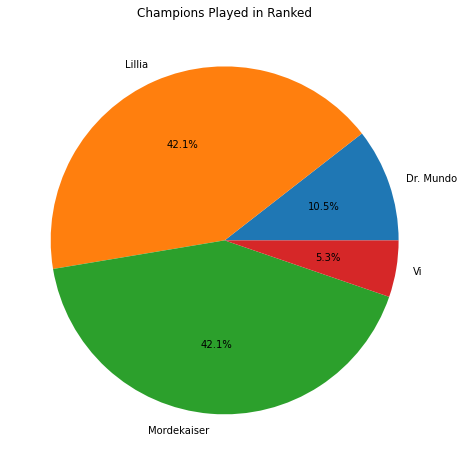

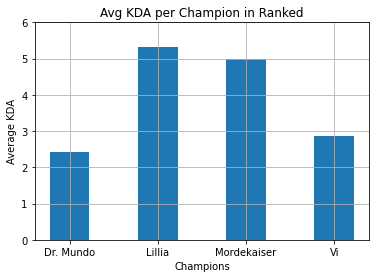

In [1189]:
utils.graphRanked(ranked_df)

For our first two graphs, we are looking at my play-rate of champions in ranked, as well as the average KDA of those champions. I am not surprised that Lillia and Mord as my top champs since this data set is so small, and I know which ones I played most off the top of my head.

The KDA also matches up, as Lillia and Mord being my most-played champions, would also be the ones that I play the best with.

Next, we are going to graph the same graphs but with my norms rolls. I'm not going to do one for ranked since it would be 100% jungle and that would not make for very interesting data.
I'm also going to make a Bar Graph along with the Pi Chart again since we have a lot more data with my normal game set, and I honestly have no idea what role will come out on top.


Roll
ADC         7
Jungle     28
Middle     30
Support     5
Top        18
dtype: int64


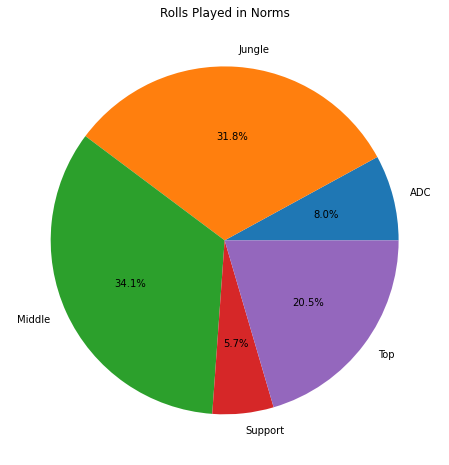

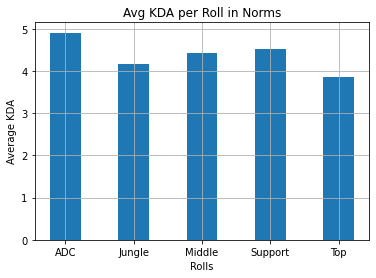

In [1190]:
utils.graphNorms(games_df)

This data was really surprising to me. All of the rolls have an extremely similar KDA, although it is kind of sad to see that my most played rolls have the lowest average...  

If I were to have gotten this data from two months ago, I think that the data would have been skewed especially towards jungle, but after playing Akali a lot (who is played top and mid), it increased those almost up to my jungle play rate.   

Lastly, I want to graph the length of my normal games vs. the length of my ranked games. As I mentioned in my graph summary, ranked games tend to go on longer than normal games since people are trying their best to win. However, my friends and I tend to play very long games when we play together so we shall see.

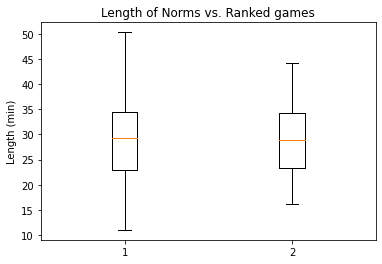

In [1199]:
utils.graphTime(games_df, ranked_df)

This graph is the one that surprised me the most out of all of them. The quartiles on both the norms and ranked are almost exactly the same, and the whiskers only being longer on norms because I have a lot more data on that set. I was really expecting ranked to be longer, at least one of the quartiles, but I guess the long games with my friends canceled it out.

# Hypothesis Testing
For my hypothesis testing, I am going to test two different hypotheses that I have. The first will be if I will beat a certain score with a specific champion, and the next will be based on if I play longer games with my friends or alone. I will explain them in more detail during their sections. These tests will give me a really interesting view of how likely these things are to happen and if I feel the same way.

1. For the first test, I will be running a hypothysis test to see if when I play a game with Akali if I will get a KDA above 3. I am doing this to see if the champ I played most in these last 100 games or so actually paid off and made me pretty good at the champion or not.

Akali KDA Test
* H0 - $M_{kda} <= 3$
* H1 - $M_{kda} > 3$
* Confidence $= 98$%
* $df = N_{akali} - 1 = 30$
* $t_{critical} = 2.457$

In [1192]:
utils.akaliHypo(games_df)

t-computed = 2.066722324107354

Average KDA of Akalis:  2.310000000000001


t-computed is less than t-critical, therefor reject H0.  

I also printed out another point of data, that the average KDA of Akali players in my rank is 2.3. So not only does my hypothesis test prove that if I play Akali, I will most likely get a KDA above 3, but also that it is significantly higher than the average person in my rank.  




2. Next is a bit weirder, but I think it should be interesting. The friends that I play with the most are better at the game than me, and because of that, the average rank of the games go up. Surprisingly, I play about the same whether I'm playing with them or not, but that is not the point. What I want to test here is if I am playing with my friends, will the game be longer than if I were playing by myself? There is an option in the game to "FF" or forfeit, which ends the game early. However, whenever my friends and I play we rarely do that because we are having fun no matter how winnable the game is.
* My thought is that if I'm playing with my friends, the length of the game will be longer than if I were playing alone


Jungle CS Test
* H0 - $M_{friends} <= M_{alone}$
* H1 - $M_{frieds} > M_{alone}$
* Confidence $= 98$%
* $df = N_{friends} + N_{alone} - 2 = 86$
* $t_{critical} = 2.390$

In [1193]:
utils.friendsHypo(games_df)

t-calculated = 2.302374480299633


t-computed is less than t-critical, therefor accept H0.  

Unfortunately, my prediction for this one was not correct; however, it was extremely close. If I move the confidence interval down it would have passed. I still think that this was a really interesting test to do, and still got quite close to my hypothesis.


# Machine Learning
First I need to label encode the data, as well as remove any of the columns that wont be necessary such as the Gamemode, since all of them are normal for this data.

In [1194]:
games_ml, newgames_df = utils.labelEncoding(games_df)

# split games_ml
X = games_ml.drop('Result', axis=1)
y = games_ml['Result']

c:\Users\akeys_abfybfs\Desktop\School\Data Science\Project\ProjectVSC\utils.py:229: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  games_ml = games_ml.append(newgames_df)


Our data is now all orginized for machine learning! All of our important data is in numbers. We have also split the data into an X and y to work with in ML.

### Decision Tree
The first data model that I will work with is a decision tree, this will give us a basic understanding of what is important in our data.

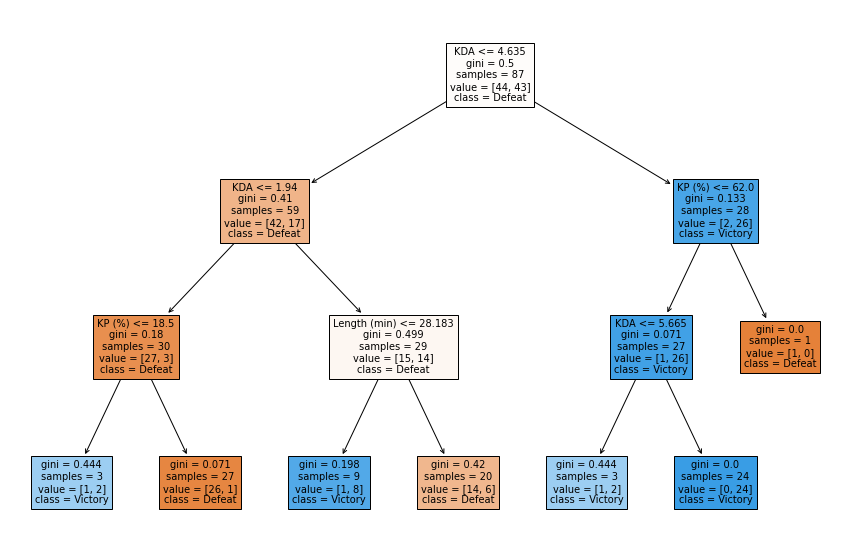

In [1195]:
clf = utils.decisionTree(X, y)

Looking at the tree, we can see that my KDA as well as how long the games are play the biggest role in whether or not I lose. Here's some basic information we can get.
* If my KDA is lower than 1.94, There is a good chance that I will lose.
* If my games last under 40 minutes, but above 30, it is probably a good sign.
* Lastly, KP also plays a slight role in the big picture.  

The thing I am most surprised about is how there is no branch that has anything to do with the champion that I picked, but I feel like that will be more important in future models such as kNN.  

### Corilation Matrix
One more thing that I want to do before making our predictions is create a correlation matrix, along with the decision tree we just made, we will get a good understanding of what is important in our data.

In [1196]:
corr_df = games_ml.corr()
corr_df.style.background_gradient(cmap='bwr').set_precision(2)

C:\Users\akeys_abfybfs\AppData\Local\Temp\ipykernel_9484\747190788.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_df.style.background_gradient(cmap='bwr').set_precision(2)


,Result,Length (min),Roll,Champion,KDA,KP (%),CS,Average Rank
Result,1.00,-0.28,0.04,-0.04,0.57,-0.06,-0.17,0.02
Length (min),-0.28,1.00,0.13,0.05,-0.08,0.13,0.70,-0.08
Roll,0.04,0.13,1.00,-0.47,-0.05,-0.12,0.04,0.05
Champion,-0.04,0.05,-0.47,1.00,0.01,-0.12,-0.01,-0.13
KDA,0.57,-0.08,-0.05,0.01,1.00,0.18,-0.07,0.12
KP (%),-0.06,0.13,-0.12,-0.12,0.18,1.00,-0.02,-0.21
CS,-0.17,0.70,0.04,-0.01,-0.07,-0.02,1.00,-0.02
Average Rank,0.02,-0.08,0.05,-0.13,0.12,-0.21,-0.02,1.00



I am very surprised by this table, especially with length and champion having such a small correlation value. KDA is unsurprisingly the most impactful attribute to if we win or lose. This makes perfect sense as the higher my KDA, the fewer deaths I have. This *usually* means that the team also has low deaths, which directly impacts winning the game.  
I was shocked to see that the champion I play has such a low impact on the outcome of the game. I thought that maybe if I was playing a champion I was better at, I would be more likely to win, but it seems that isn't always the case.  

Something that doesn't correlate to the result of the game, but I still find really impressive is the correlation between Length and CS. I didn't go much in-depth about CS, but almost always the longer a game is, the higher your CS will be. I thought it was cool to see such a high correlation value make sense to me right away.


### Accuracy Testing
Before we predict our games, I want to take a look at how accurate we can expect our predictions to be. I will find the r2 score for both the kNN and Decision Tree and print the results.

In [1197]:
knn = utils.accuracyTesting(X, y, clf)

kNN score: 0.6818181818181818
Decision Tree score: 0.9090909090909091


With these r2 scores, we can expect our Decision Tree predictions to be a bit more accurate than our kNN predictions. I am actually very impressed with the accuracy of these models, especially the Decision Tree. I really was not expecting to get great predictions at the beginning of this project because of all the small parts that play a role in a single League of Legends game, but I am pleasantly surprised.   

Now, for what we've been waiting for this whole time...



### Predictions


In [1198]:
utils.mlPredictions(newgames_df, knn, clf)

kNN Predictions [0 0 1 1 0 1 1 1 1 0]
Decision Tree Predictions [0 0 0 1 0 1 0 0 1 1]

Real Results
0 1 1 1 0 1 0 1 1 1 

kNN Accuracy - 70 %
Decision Accuracy - 70 %


I'm quite impressed with the accuracy of our predictions! Especially since it's taking data from only 1 of the 10 players in any given game.  
* kNN predicted the outcome with 70% accuracy
* Decision Tree predicted the outcome with 80% accuracy  

This actually lines up pretty well with our r2 scores that we just tested. Our kNN score was 68%, and our Decision Tree was 90%. The actual results of the Decision Tree was slightly off but besides that incredibly accurate. As our Decision Tree and Correlation table showed, I think that KDA was the biggest attribute in our predictions. Although there are plenty of times when one or two people on the team can have a very high KDA and still lose, it is a lot less common than having a good KDA and winning. I think that along with how long the game went on really helped out our decision tree predictions. If the game ends earlier, your KDA could possibly be a lot higher than it would if the game kept going on. As games go on, it gets a lot easier for people to die, even if they're doing amazing beforehand. With the combination of these two, we got a really good prediction out of data that I thought would be a lot harder to predict

## Conclusion

After all of our cleaning, analyzing, graphing, and predicting, I think we have learned a lot about my game data. The key points that I have taken away from this project are:
* I play a lot more consistently than I expected, even in the roles and champions that I am not as good at
* The time I spend playing is a lot more consistent than I thought
* Playing with my friends takes more time than playing alone, but that's probably for the best
* I have improved a lot with the champion I played the most with over the past couple of months
* But most importantly, machine learning is just as interesting as I was hoping it would be and can be an extremely impressive and useful tool if you know what you're doing  

Overall, I learned more than I thought I could through this project. Throughout the year, I was struggling to keep up with all the new techniques we were learning, but being able to use all of them in one final project really made everything feel complete and meaningful. This project will definitely help me throughout the next years in college and I cannot wait to work with Kaggle and other data science projects in the future.